In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import torch

a = 1
d = 1
Re = 4e-4
Pe = 2.8e-4
Nu = 0.023 * Re ** (0.8) * 0.7 ** 0.4
torch.set_default_device('cuda')
def pde(x, u):
    u_vel, v_vel, w_vel, p, Thetta = u[:, 0:1], u[:, 1:2], u[:, 2:3], u[:, 3:4], u[:, 4:5]
    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_z = dde.grad.jacobian(u, x, i=0, j=2)
    u_vel_t = dde.grad.jacobian(u, x, i=0, j=3)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)
    u_vel_zz = dde.grad.hessian(u, x, component=0, i=2, j=2)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_z = dde.grad.jacobian(u, x, i=1, j=2)
    v_vel_t = dde.grad.jacobian(u, x, i=1, j=3)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)
    v_vel_zz = dde.grad.hessian(u, x, component=1, i=2, j=2)

    w_vel_x = dde.grad.jacobian(u, x, i=2, j=0)
    w_vel_y = dde.grad.jacobian(u, x, i=2, j=1)
    w_vel_z = dde.grad.jacobian(u, x, i=2, j=2)
    w_vel_t = dde.grad.jacobian(u, x, i=2, j=3)
    w_vel_xx = dde.grad.hessian(u, x, component=2, i=0, j=0)
    w_vel_yy = dde.grad.hessian(u, x, component=2, i=1, j=1)
    w_vel_zz = dde.grad.hessian(u, x, component=2, i=2, j=2)

    p_x = dde.grad.jacobian(u, x, i=3, j=0)
    p_y = dde.grad.jacobian(u, x, i=3, j=1)
    p_z = dde.grad.jacobian(u, x, i=3, j=2)
    
    Thetta_dt = dde.grad.jacobian(u, x, i = 4, j = 3)

    Thetta_dxx = dde.grad.hessian(u, x, component = 4, i = 0, j = 0)
    Thetta_dyy = dde.grad.hessian(u, x, component = 4, i = 1, j = 1)
    Thetta_dzz = dde.grad.hessian(u, x, component = 4, i = 2, j = 2)
    
    energy_x = Thetta_dt + (u_vel_x + u_vel_y + u_vel_z) * Thetta - 1 / Pe * (Thetta_dxx + Thetta_dyy + Thetta_dzz)
    energy_y = Thetta_dt + (v_vel_x + v_vel_y + v_vel_z) * Thetta - 1 / Pe * (Thetta_dxx + Thetta_dyy + Thetta_dzz)
    energy_z = Thetta_dt + (w_vel_x + w_vel_y + w_vel_z) * Thetta - 1 / Pe * (Thetta_dxx + Thetta_dyy + Thetta_dzz)
    
    momentum_x = (
        u_vel_t
        + (u_vel * u_vel_x + v_vel * u_vel_y + w_vel * u_vel_z)
        + p_x
        - 1 / Re * (u_vel_xx + u_vel_yy + u_vel_zz)
    )
    momentum_y = (
        v_vel_t
        + (u_vel * v_vel_x + v_vel * v_vel_y + w_vel * v_vel_z)
        + p_y
        - 1 / Re * (v_vel_xx + v_vel_yy + v_vel_zz)
    )
    momentum_z = (
        w_vel_t
        + (u_vel * w_vel_x + v_vel * w_vel_y + w_vel * w_vel_z)
        + p_z
        - 1 / Re * (w_vel_xx + w_vel_yy + w_vel_zz)
    )
    continuity = u_vel_x + v_vel_y + w_vel_z

    energy = torch.sqrt(torch.square(energy_x) +
                        torch.square(energy_y) +
                        torch.square(energy_z))
    return [momentum_x, momentum_y, momentum_z, continuity, energy]


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
def u_func(x):
    return (
        -a
        * (
            np.exp(a * x[:, 0:1]) * np.sin(a * x[:, 1:2] + d * x[:, 2:3])
            + np.exp(a * x[:, 2:3]) * np.cos(a * x[:, 0:1] + d * x[:, 1:2])
        )
        * np.exp(-(d ** 2) * x[:, 3:4])
    )


def v_func(x):
    return (
        -a
        * (
            np.exp(a * x[:, 1:2]) * np.sin(a * x[:, 2:3] + d * x[:, 0:1])
            + np.exp(a * x[:, 0:1]) * np.cos(a * x[:, 1:2] + d * x[:, 2:3])
        )
        * np.exp(-(d ** 2) * x[:, 3:4])
    )


def w_func(x):
    return (
        -a
        * (
            np.exp(a * x[:, 2:3]) * np.sin(a * x[:, 0:1] + d * x[:, 1:2])
            + np.exp(a * x[:, 1:2]) * np.cos(a * x[:, 2:3] + d * x[:, 0:1])
        )
        * np.exp(-(d ** 2) * x[:, 3:4])
    )


def p_func(x):
    return (
        -0.5
        * a ** 2
        * (
            np.exp(2 * a * x[:, 0:1])
            + np.exp(2 * a * x[:, 1:2])
            + np.exp(2 * a * x[:, 2:3])
            + 2
            * np.sin(a * x[:, 0:1] + d * x[:, 1:2])
            * np.cos(a * x[:, 2:3] + d * x[:, 0:1])
            * np.exp(a * (x[:, 1:2] + x[:, 2:3]))
            + 2
            * np.sin(a * x[:, 1:2] + d * x[:, 2:3])
            * np.cos(a * x[:, 0:1] + d * x[:, 1:2])
            * np.exp(a * (x[:, 2:3] + x[:, 0:1]))
            + 2
            * np.sin(a * x[:, 2:3] + d * x[:, 0:1])
            * np.cos(a * x[:, 1:2] + d * x[:, 2:3])
            * np.exp(a * (x[:, 0:1] + x[:, 1:2]))
        )
        * np.exp(-2 * d ** 2 * x[:, 3:4])
    )

In [3]:
spatial_domain = dde.geometry.Cuboid(xmin=[-2, -2, -2], xmax=[2, 2, 2])
spatial_plate = dde.geometry.Cuboid(xmin = [-0.5, -1, -0.125], xmax = [0.5, 1, 0.125])

new_domain = dde.geometry.CSGUnion(spatial_domain,
                                   spatial_plate)

temporal_domain = dde.geometry.TimeDomain(0, 1)
spatio_temporal_domain = dde.geometry.GeometryXTime(new_domain, 
                                                    temporal_domain)

In [4]:
test = spatio_temporal_domain.random_points(n = 100)

In [6]:
boundary_condition_u = dde.icbc.DirichletBC(
    spatio_temporal_domain, u_func, lambda _, on_boundary: on_boundary, component=0
)
boundary_condition_v = dde.icbc.DirichletBC(
    spatio_temporal_domain, v_func, lambda _, on_boundary: on_boundary, component=1
)
boundary_condition_w = dde.icbc.DirichletBC(
    spatio_temporal_domain, w_func, lambda _, on_boundary: on_boundary, component=2
)

boundary_condition_theta = dde.icbc.NeumannBC(
    spatio_temporal_domain, lambda x: Nu * (383 - 291), lambda _, on_boundary: on_boundary, component = 4
)

initial_condition_u = dde.icbc.IC(
    spatio_temporal_domain, lambda x: 1, lambda _, on_initial: on_initial, component=0
)
initial_condition_v = dde.icbc.IC(
    spatio_temporal_domain, lambda x: 1, lambda _, on_initial: on_initial, component=1
)
initial_condition_w = dde.icbc.IC(
    spatio_temporal_domain, lambda x: 1, lambda _, on_initial: on_initial, component=2
)
initial_condition_theta = dde.icbc.IC(
    spatio_temporal_domain, lambda x: 383 if np.all(np.any(np.isclose(x[:, :3], 
                                                                np.array([-0.5, -1, -0.125])
                                                               ), axis = 0
                                                    ) |
                                              np.any(np.isclose(x[:, :3],
                                                                np.array([0.5, 1, 0.125])
                                                               ), axis = 0
                                                    )) else 291, lambda _, on_initial: on_initial, component = 4)
initial_condition_p = dde.icbc.IC(
    spatio_temporal_domain, lambda x: 1e5, lambda _, on_initial: on_initial, component = 3
)

In [7]:
data = dde.data.TimePDE(
    spatio_temporal_domain,
    pde,
    [
        boundary_condition_u,
        boundary_condition_v,
        boundary_condition_w,
        boundary_condition_theta,
        initial_condition_u,
        initial_condition_v,
        initial_condition_w,
        initial_condition_theta
    ],
    num_domain=50000,
    num_boundary=5000,
    num_initial=5000,
    num_test=10000,
)

net = dde.nn.FNN([4] + 4 * [50] + [5], "tanh", "Glorot normal")

In [8]:
torch.cuda.empty_cache()

In [9]:
model = dde.Model(data, net)

model.compile("adam", lr=1e-3, loss_weights=[1, 1, 1, 1, 1] + [1] * 7)
losshistory, trainstate = model.train(iterations=30000)

Compiling model...
'compile' took 1.157782 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [3.62e+05, 1.59e+05, 1.82e+05, 4.59e-02, 2.66e+05, 5.50e+00, 6.22e+00, 6.07e+00, 5.87e-03, 1.17e+00, 1.13e+00, 1.10e+00]    [3.73e+05, 1.56e+05, 1.84e+05, 4.49e-02, 2.67e+05, 5.50e+00, 6.22e+00, 6.07e+00, 5.87e-03, 1.17e+00, 1.13e+00, 1.10e+00]    []  
1000      [1.80e+01, 1.45e+01, 1.16e+01, 5.14e-04, 2.64e+01, 6.06e+00, 5.98e+00, 6.18e+00, 2.12e-04, 2.94e-01, 3.97e-01, 2.71e-01]    [1.59e+01, 1.42e+01, 1.11e+01, 5.26e-04, 2.61e+01, 6.06e+00, 5.98e+00, 6.18e+00, 2.12e-04, 2.94e-01, 3.97e-01, 2.71e-01]    []  
2000      [5.02e+00, 4.97e+00, 3.34e+00, 4.01e-04, 9.57e+00, 6.09e+00, 6.09e+00, 6.19e+00, 1.14e-04, 2.52e-01, 2.58e-01, 2.60e-01]    [4.58

Text(0.5, 1.0, 'Temperature loss distribution')

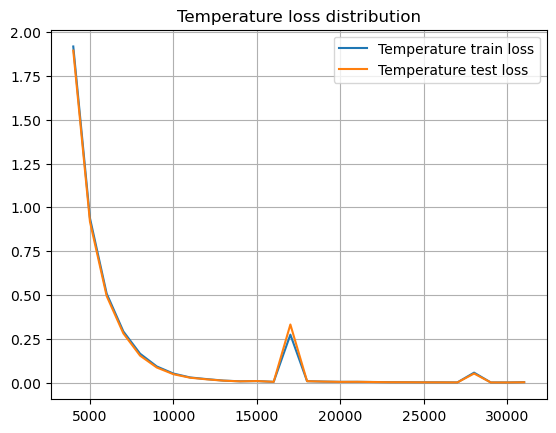

In [103]:
plt.plot(losshistory.steps[4:],
         np.array(losshistory.loss_train)[4:, 4:5]
        )
plt.plot(losshistory.steps[4:],
         np.array(losshistory.loss_test)[4:, 4:5])
plt.grid()
plt.legend(['Temperature train loss',
            'Temperature test loss'])
plt.title('Temperature loss distribution')

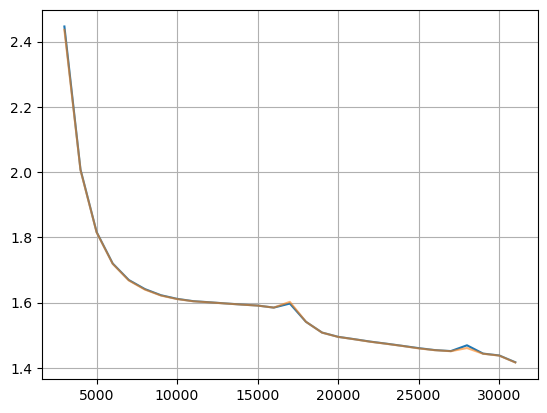

In [101]:
plt.plot(losshistory.steps[3:],
         np.mean(np.array(losshistory.loss_train).T, axis = 0)[3:])
plt.plot(losshistory.steps[3:],
         np.mean(np.array(losshistory.loss_test).T, axis = 0)[3:],
        alpha = 0.6)
plt.grid()
plt.show()

In [81]:
model.compile("L-BFGS", loss_weights=[1, 1, 1, 1, 1] + [1] * 7)
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.001401 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
30000     [6.68e-03, 5.24e-03, 5.52e-03, 8.84e-04, 7.20e-04, 5.68e+00, 5.71e+00, 5.79e+00, 1.29e-05, 1.97e-02, 1.70e-02, 1.63e-02]    [4.75e-03, 3.55e-03, 3.71e-03, 9.68e-04, 5.61e-04, 5.68e+00, 5.71e+00, 5.79e+00, 1.29e-05, 1.97e-02, 1.70e-02, 1.63e-02]    []  
31000     [5.83e-03, 7.36e-03, 7.23e-03, 3.29e-03, 2.34e-03, 5.57e+00, 5.58e+00, 5.68e+00, 1.36e-04, 4.84e-02, 4.63e-02, 4.30e-02]    [3.31e-03, 4.83e-03, 5.60e-03, 2.78e-03, 1.72e-03, 5.57e+00, 5.58e+00, 5.68e+00, 1.36e-04, 4.84e-02, 4.63e-02, 4.30e-02]    []  


KeyboardInterrupt: 